In [1]:
from psifr import fr
import pybeh_pd as pb
import cmlreaders as cml
import pkg_resources
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data_file = pkg_resources.resource_filename('psifr', 'data/Morton2013.csv')
import importlib
importlib.reload(pb)

<module 'pybeh_pd' from '/Users/davidhalpern/Documents/GitHub/pybeh_pd/pybeh_pd.py'>

# Using psifr sample data

In [2]:
df = pd.read_csv(data_file, dtype={'category': 'category'})
df.category.cat.as_ordered(inplace=True)

In [3]:
# Organizing data for psifr
data = fr.merge_free_recall(df, study_keys=['category'])
crp = fr.lag_crp(data)
crp

prob  actual  possible
subject lag                              
1       -23.0  0.020833       1        48
        -22.0  0.035714       3        84
        -21.0  0.026316       3       114
        -20.0  0.024000       3       125
        -19.0  0.014388       2       139
...                 ...     ...       ...
47       19.0  0.061224       3        49
         20.0  0.055556       2        36
         21.0  0.045455       1        22
         22.0  0.071429       1        14
         23.0  0.000000       0         6

[1880 rows x 3 columns]

Text(0.5, 1.0, 'psifr CRP')

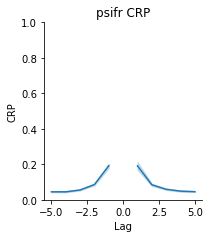

In [4]:
# psiFR plotting
g = fr.plot_lag_crp(crp)
plt.title('psifr CRP')

In [5]:
# Computing lag crp curves with pd_to_pb
crp_pb = df.groupby('subject').apply(pb.pd_crp, itemno_column="item_number", pres_type="study", 
                            rec_type="recall", type_column='trial_type', lag_num=23).reset_index()

Text(0.5, 1.0, 'pd_pybeh CRP')

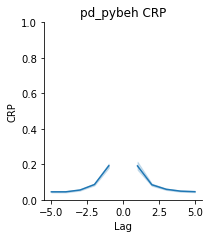

In [8]:
# Plotting the pd_to_pb results using psifr
g = fr.plot_lag_crp(crp_pb)
plt.title('pd_pybeh CRP')

<AxesSubplot:xlabel='lag', ylabel='prob'>

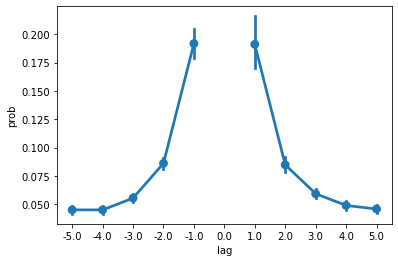

In [9]:
# Plotting using pure seaborn
sns.pointplot(x='lag', y='prob', data=crp.reset_index().query(
    'lag <= 5 and lag >= -5'))

# Testing on CML data (single session)

In [10]:
ix = cml.CMLReader.get_data_index(rootdir='~/rhino_mount/')

In [11]:
df_sess = ix.query('experiment == "FR1"').iloc[0]
events = cml.CMLReader(subject=df_sess['subject'], experiment=df_sess['experiment'], 
                       session=df_sess['session'], localization=df_sess['localization'], 
                       montage=df_sess['montage'], rootdir='~/rhino_mount/'
                      ).load('task_events')

In [13]:
# Reorganizing for psifr
events.rename(columns={'item_name': 'item'}, inplace=True)
word_evs = events.query('type == "WORD"')
rec_evs = events.query('type == "REC_WORD"')
rec_evs['position'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount() 
word_evs['position'] = word_evs['serialpos']

/Users/davidhalpern/opt/anaconda3/envs/cml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/davidhalpern/opt/anaconda3/envs/cml/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
merged = fr.merge_lists(word_evs, rec_evs, 
                        merge_keys=['subject', 'session', 'list', 'item'])

In [15]:
crp = fr.lag_crp(merged)
crp.query('lag <= 5 and lag >= -5')

prob  actual  possible
subject lag                             
R1001P  -5.0  0.111111       1         9
        -4.0  0.000000       0         9
        -3.0  0.062500       1        16
        -2.0  0.000000       0        16
        -1.0  0.117647       2        17
         0.0       NaN       0         0
         1.0  0.285714       6        21
         2.0  0.111111       2        18
         3.0  0.117647       2        17
         4.0  0.266667       4        15
         5.0  0.000000       0        14

In [16]:
# This is all you need to do with pd_to_pb to get th esame thing:
events.groupby('subject').apply(pb.pd_crp, itemno_column="item_num").reset_index()

,subject,level_1,prob,lag
0,R1001P,-5,0.111111,-5
1,R1001P,-4,0.000000,-4
2,R1001P,-3,0.062500,-3
3,R1001P,-2,0.000000,-2
4,R1001P,-1,0.117647,-1
5,R1001P,0,NaN,0
6,R1001P,1,0.285714,1
7,R1001P,2,0.111111,2
8,R1001P,3,0.117647,3
9,R1001P,4,0.266667,4


# Testing on CML data (multiple sessions from one subject)

In [17]:
all_events = []
for _, df_sess in ix.query('experiment == "FR1" and subject == "R1001P"').iterrows():
    try:
        sess_events = cml.CMLReader(subject=df_sess['subject'], 
                                    experiment=df_sess['experiment'], 
                                    session=df_sess['session'], 
                                    localization=df_sess['localization'], 
                                    montage=df_sess['montage'],
                                    rootdir='~/rhino_mount/'
                                   ).load('task_events')
        all_events.append(sess_events)
    except:
        continue

events = pd.concat(all_events)

In [18]:
# Organizing for psifr
events.rename(columns={'item_name': 'item'}, inplace=True)
word_evs = events.query('type == "WORD"')
rec_evs = events.query('type == "REC_WORD"')
rec_evs['position'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount() 
word_evs['position'] = word_evs['serialpos']

merged = fr.merge_lists(word_evs, rec_evs, 
                        merge_keys=['subject', 'session', 'list', 'item'])

/Users/davidhalpern/opt/anaconda3/envs/cml/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/davidhalpern/opt/anaconda3/envs/cml/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
psifr_crp = fr.lag_crp(merged)

In [20]:
pb_crp = events.groupby('subject').apply(pb.pd_crp, 
                                itemno_column='item_num')

(0.0, 0.3)

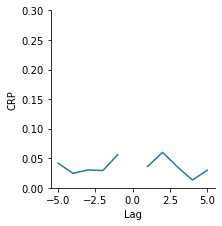

In [21]:
#Plotting the psifr result
g = fr.plot_lag_crp(psifr_crp)
g.ax.set_ylim(0, .3)

(0.0, 0.3)

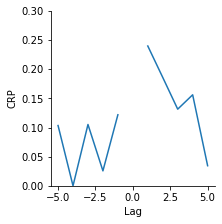

In [23]:
#plotting the pd_to_pb result
g = fr.plot_lag_crp(pb_crp)
g.ax.set_ylim(0, .3)

Reason for the difference is becaue psifr only uses one list index when it computes CRP -- to take into account session, you need [session, list] as index so the pd_to_pb version is correct